# 🎯 DeepAR Training Pipeline

**Ziel:** Trainiere probabilistisches Forecasting-Model für Retail Inventory

---

## 📋 Workflow

1. **Setup & Config** - Hyperparameter definieren
2. **Daten laden** - CSV einlesen & sortieren
3. **Feature Engineering** - Lags, Rolling Stats, Date Features
4. **Train/Test Split** - 80/20 Split
5. **Sequenzen erstellen** - Time-Series Windows (30 Tage)
6. **Normalisierung** - StandardScaler
7. **Model Training** - DeepAR mit Gaussian NLL Loss
8. **Evaluation** - MAE, RMSE, MAPE, Coverage
9. **Visualisierung** - Loss Curves, Predictions
10. **Speichern** - Model, Scaler, Metrics

**⏱️ Geschätzte Dauer:** 5-10 Minuten (SCHNELL-CONFIG)

---

## 1️⃣ Imports & Setup

In [1]:
import numpy as np
import pandas as pd
import pickle
import json
from pathlib import Path
from dataclasses import dataclass, field
from typing import List, Tuple

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Notebook Settings
%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✅ Imports erfolgreich")
print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU verfügbar: {len(tf.config.list_physical_devices('GPU')) > 0}")

✅ Imports erfolgreich
TensorFlow Version: 2.19.1
GPU verfügbar: False


## 2️⃣ Configuration

**⚡ SCHNELL-CONFIG:** Optimiert für 5-10 Minuten Training

In [2]:
@dataclass
class Config:
    """Training Configuration"""
    # Pfade
    data_path: str = "retail_store_inventory.csv"
    target_col: str = 'Units Sold'
    model_dir: str = "models"
    
    # Sequenz & Training
    seq_length: int = 30              # ⚡ 30 Tage Zeitfenster
    test_size: float = 0.2
    batch_size: int = 512             # ⚡ Große Batches = schneller
    epochs: int = 50                  # ⚡ 50 Epochen (statt 100)
    patience: int = 5                 # ⚡ Früh stoppen
    
    # Model Architektur
    use_bidirectional: bool = True
    lstm_layers: int = 2
    lstm_units_1: int = 128           # ⚡ Kleiner (statt 256)
    lstm_units_2: int = 64            # ⚡ Kleiner (statt 128)
    dense_units: int = 32             # ⚡ Kleiner (statt 64)
    dense_activation: str = 'relu'
    dropout: float = 0.3
    l2_reg: float = 0.0002
    
    # Optimizer
    learning_rate: float = 0.001      # ⚡ 5x schneller (statt 0.0002)
    use_lr_scheduler: bool = True
    lr_factor: float = 0.5
    lr_patience: int = 3
    lr_min: float = 0.00001
    
    # Feature Engineering
    lag_periods: List[int] = field(default_factory=lambda: [1, 7, 30])
    rolling_windows: List[int] = field(default_factory=lambda: [7, 30])


# Initialisiere Config
config = Config()

print("="*70)
print("⚡ TRAINING CONFIGURATION")
print("="*70)
print(f"Sequenz:          {config.seq_length} Tage")
print(f"LSTM:             {config.lstm_units_1}→{config.lstm_units_2} Units")
print(f"Batch Size:       {config.batch_size}")
print(f"Max Epochen:      {config.epochs}")
print(f"Early Stop:       Patience={config.patience}")
print(f"Learning Rate:    {config.learning_rate}")
print(f"Geschätzte Zeit:  5-10 Minuten ⚡")
print("="*70)

⚡ TRAINING CONFIGURATION
Sequenz:          30 Tage
LSTM:             128→64 Units
Batch Size:       512
Max Epochen:      50
Early Stop:       Patience=5
Learning Rate:    0.001
Geschätzte Zeit:  5-10 Minuten ⚡


## 3️⃣ Daten laden

In [3]:
print("📊 Lade Daten...")
df = pd.read_csv(config.data_path)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Store ID', 'Product ID', 'Date']).reset_index(drop=True)

print(f"✅ {len(df):,} Datenpunkte geladen")
print(f"✅ Zeitraum: {df['Date'].min()} bis {df['Date'].max()}")
print(f"✅ Stores: {df['Store ID'].nunique()}")
print(f"✅ Products: {df['Product ID'].nunique()}")
print()
df.head()

📊 Lade Daten...
✅ 73,100 Datenpunkte geladen
✅ Zeitraum: 2022-01-01 00:00:00 bis 2024-01-01 00:00:00
✅ Stores: 5
✅ Products: 20



,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-02,S001,P0001,Groceries,West,116,81,104,92.94,27.95,10,Cloudy,0,30.89,Spring
2,2022-01-03,S001,P0001,Electronics,West,154,5,189,5.36,62.70,20,Rainy,0,58.22,Winter
3,2022-01-04,S001,P0001,Groceries,South,85,58,193,52.87,77.88,15,Cloudy,1,75.99,Winter
4,2022-01-05,S001,P0001,Groceries,South,238,147,37,150.27,28.46,20,Sunny,1,29.40,Winter


## 4️⃣ Feature Engineering

Erstelle:
- **Date Features:** Year, Month, Day, DayOfWeek, Quarter, WeekOfYear
- **Lag Features:** t-1, t-7, t-30
- **Rolling Features:** Mean & Std (7 & 30 Tage)

In [15]:
def create_features(df, target_col, lag_periods, rolling_windows):
    """Erstellt Lag- und Rolling Features + One-Hot Encoding für kategorische Variablen"""
    df = df.copy()
    
    # One-Hot Encoding für kategorische Variablen
    categorical_cols = ['Category', 'Region', 'Weather Condition', 'Seasonality']
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=int)
    
    # Datum Features
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['Quarter'] = df['Date'].dt.quarter
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week
    
    # Lag Features
    for lag in lag_periods:
        df[f'{target_col}_lag_{lag}'] = df.groupby(['Store ID', 'Product ID'])[target_col].shift(lag)
    
    # Rolling Features
    for window in rolling_windows:
        # Rolling Mean
        rolling_mean = df.groupby(['Store ID', 'Product ID'])[target_col].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean()
        )
        df[f'{target_col}_rolling_mean_{window}'] = rolling_mean
        
        # Rolling Std
        rolling_std = df.groupby(['Store ID', 'Product ID'])[target_col].transform(
            lambda x: x.rolling(window=window, min_periods=1).std()
        )
        df[f'{target_col}_rolling_std_{window}'] = rolling_std
    
    return df

print("🔧 Feature Engineering...")
df = create_features(df, config.target_col, config.lag_periods, config.rolling_windows)
df = df.dropna().reset_index(drop=True)

print(f"✅ Features erstellt: {len(df.columns)} Spalten")
print(f"✅ Nach Bereinigung: {len(df):,} Datenpunkte")
print(f"✅ One-Hot Encoding: Category, Region, Weather, Seasonality")
print()
print("Feature Spalten:")
print(df.columns.tolist())

🔧 Feature Engineering...


KeyError: "None of [Index(['Category', 'Region', 'Weather Condition', 'Seasonality'], dtype='object')] are in the [columns]"

## 5️⃣ Train/Test Split

**80/20 Split** (zeitlich, kein Shuffle!)

In [5]:
print("🔀 Train/Test Split...")

# Ausschließen: Nur ID und Target Spalten
exclude_cols = ['Date', 'Store ID', 'Product ID', config.target_col]

feature_cols = [col for col in df.columns if col not in exclude_cols]

df_train, df_test = train_test_split(df, test_size=config.test_size, shuffle=False)

print(f"✅ Training:   {len(df_train):,} samples ({(1-config.test_size)*100:.0f}%)")
print(f"✅ Test:       {len(df_test):,} samples ({config.test_size*100:.0f}%)")
print(f"✅ Features:   {len(feature_cols)}")
print()
print("Feature Columns:")
print(feature_cols)

🔀 Train/Test Split...
✅ Training:   56,080 samples (80%)
✅ Test:       14,020 samples (20%)
✅ Features:   33

Feature Columns:
['Inventory Level', 'Units Ordered', 'Demand Forecast', 'Price', 'Discount', 'Holiday/Promotion', 'Competitor Pricing', 'Category_Electronics', 'Category_Furniture', 'Category_Groceries', 'Category_Toys', 'Region_North', 'Region_South', 'Region_West', 'Weather Condition_Rainy', 'Weather Condition_Snowy', 'Weather Condition_Sunny', 'Seasonality_Spring', 'Seasonality_Summer', 'Seasonality_Winter', 'Year', 'Month', 'Day', 'DayOfWeek', 'Quarter', 'WeekOfYear', 'Units Sold_lag_1', 'Units Sold_lag_7', 'Units Sold_lag_30', 'Units Sold_rolling_mean_7', 'Units Sold_rolling_std_7', 'Units Sold_rolling_mean_30', 'Units Sold_rolling_std_30']
✅ Training:   56,080 samples (80%)
✅ Test:       14,020 samples (20%)
✅ Features:   33

Feature Columns:
['Inventory Level', 'Units Ordered', 'Demand Forecast', 'Price', 'Discount', 'Holiday/Promotion', 'Competitor Pricing', 'Category_

## 6️⃣ Sequenz-Erstellung

Erstelle **30-Tage Zeitfenster** für LSTM Input

In [6]:
def create_sequences(df, feature_cols, target_col, seq_length):
    """Erstellt Time-Series Sequenzen"""
    X, y = [], []
    
    for (store, product), group in df.groupby(['Store ID', 'Product ID']):
        if len(group) < seq_length + 1:
            continue
            
        features = group[feature_cols].values
        target = group[target_col].values
        
        for i in range(len(group) - seq_length):
            X.append(features[i:i+seq_length])
            y.append(target[i+seq_length])
    
    return np.array(X), np.array(y)

print("🔢 Erstelle Sequenzen...")
X_train, y_train = create_sequences(df_train, feature_cols, config.target_col, config.seq_length)
X_test, y_test = create_sequences(df_test, feature_cols, config.target_col, config.seq_length)

print(f"✅ Training:   X={X_train.shape}, y={y_train.shape}")
print(f"✅ Test:       X={X_test.shape}, y={y_test.shape}")
print()
print(f"Input Shape:  (batch_size, {config.seq_length}, {len(feature_cols)})")
print(f"Output Shape: (batch_size, 2)  # μ und σ")

🔢 Erstelle Sequenzen...
✅ Training:   X=(53680, 30, 33), y=(53680,)
✅ Test:       X=(13420, 30, 33), y=(13420,)

Input Shape:  (batch_size, 30, 33)
Output Shape: (batch_size, 2)  # μ und σ
✅ Training:   X=(53680, 30, 33), y=(53680,)
✅ Test:       X=(13420, 30, 33), y=(13420,)

Input Shape:  (batch_size, 30, 33)
Output Shape: (batch_size, 2)  # μ und σ


## 7️⃣ Normalisierung

**StandardScaler:** Mean=0, Std=1

In [7]:
print("📏 Normalisiere Daten...")

scaler_X = StandardScaler()
scaler_y = StandardScaler()

# X skalieren
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_train_scaled = scaler_X.fit_transform(X_train_reshaped).reshape(X_train.shape)

X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
X_test_scaled = scaler_X.transform(X_test_reshaped).reshape(X_test.shape)

# y skalieren
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

print(f"✅ X scaled: mean={X_train_scaled.mean():.4f}, std={X_train_scaled.std():.4f}")
print(f"✅ y scaled: mean={y_train_scaled.mean():.4f}, std={y_train_scaled.std():.4f}")

📏 Normalisiere Daten...
✅ X scaled: mean=0.0000, std=1.0000
✅ y scaled: mean=-0.0000, std=1.0000
✅ X scaled: mean=0.0000, std=1.0000
✅ y scaled: mean=-0.0000, std=1.0000


## 8️⃣ Baseline Model

**Naive Forecast:** Immer den Mean vorhersagen

In [8]:
print("🎯 Berechne Baseline (Naive Forecast)...")

y_test_original = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).ravel()
baseline_mae = np.mean(np.abs(y_test_original - y_test_original.mean()))
baseline_std = y_test_original.std()

print(f"✅ Baseline MAE:  {baseline_mae:.2f}")
print(f"✅ Baseline STD:  {baseline_std:.2f}")
print()
print("💡 Das DeepAR Model sollte besser sein als diese Baseline!")

🎯 Berechne Baseline (Naive Forecast)...
✅ Baseline MAE:  89.72
✅ Baseline STD:  109.70

💡 Das DeepAR Model sollte besser sein als diese Baseline!


## 9️⃣ Model Definition

**DeepAR Architecture:**
- **Input:** (30, features) - 30 Tage Zeitfenster
- **Bidirectional LSTM 1:** 128 Units
- **Bidirectional LSTM 2:** 64 Units
- **Dense:** 32 Units
- **Output:** 2 Units (μ und σ) - Probabilistische Vorhersage

**Loss:** Gaussian Negative Log-Likelihood

In [9]:
def gaussian_nll_loss(y_true, y_pred):
    """Gaussian Negative Log-Likelihood Loss"""
    mu = y_pred[:, 0]
    sigma = tf.nn.softplus(y_pred[:, 1]) + 1e-6
    loss = 0.5 * tf.math.log(2 * np.pi * sigma**2) + 0.5 * ((y_true - mu) ** 2) / (sigma**2)
    return tf.reduce_mean(loss)

print("🧠 Baue DeepAR Model...")

# Input Layer
inputs = layers.Input(shape=(config.seq_length, len(feature_cols)))

# LSTM Layer 1
if config.use_bidirectional:
    x = layers.Bidirectional(
        layers.LSTM(config.lstm_units_1, return_sequences=(config.lstm_layers > 1),
                   kernel_regularizer=regularizers.l2(config.l2_reg))
    )(inputs)
else:
    x = layers.LSTM(config.lstm_units_1, return_sequences=(config.lstm_layers > 1),
                   kernel_regularizer=regularizers.l2(config.l2_reg))(inputs)

x = layers.Dropout(config.dropout)(x)

# LSTM Layer 2 (optional)
if config.lstm_layers > 1:
    if config.use_bidirectional:
        x = layers.Bidirectional(
            layers.LSTM(config.lstm_units_2, kernel_regularizer=regularizers.l2(config.l2_reg))
        )(x)
    else:
        x = layers.LSTM(config.lstm_units_2, kernel_regularizer=regularizers.l2(config.l2_reg))(x)
    x = layers.Dropout(config.dropout)(x)

# Dense Layer
x = layers.Dense(config.dense_units, activation=config.dense_activation,
                kernel_regularizer=regularizers.l2(config.l2_reg))(x)
x = layers.Dropout(config.dropout)(x)

# Output: μ (mean) und σ (std)
outputs = layers.Dense(2, name='distribution_params')(x)

# Model kompilieren
model = models.Model(inputs=inputs, outputs=outputs, name='DeepAR')
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=config.learning_rate),
    loss=gaussian_nll_loss
)

print(f"✅ Model erstellt: {model.count_params():,} Parameter")
model.summary()

🧠 Baue DeepAR Model...
✅ Model erstellt: 334,434 Parameter


Model: "DeepAR"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 33)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 30, 256)        │       165,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ distribution_params (Dense)     │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 334,434 (1.28 MB)

 Trainable params: 334,434 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

## 🔟 Training

**⏱️ Geschätzte Dauer:** 5-10 Minuten

**Callbacks:**
- **EarlyStopping:** Stoppt bei Patience=5
- **ReduceLROnPlateau:** Reduziert LR bei Stagnation

In [10]:
print("🚀 Starte Training...")
print(f"⏱️  Geschätzte Dauer: 5-10 Minuten")
print()

# Custom Callback um LR zu tracken
class LRLogger(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = float(self.model.optimizer.learning_rate)

# Callbacks
callback_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=config.patience,
        restore_best_weights=True,
        verbose=1
    ),
    LRLogger()  # LR immer tracken
]

if config.use_lr_scheduler:
    callback_list.append(
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=config.lr_factor,
            patience=config.lr_patience,
            min_lr=config.lr_min,
            verbose=1
        )
    )

# Training
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_test_scaled, y_test_scaled),
    epochs=config.epochs,
    batch_size=config.batch_size,
    callbacks=callback_list,
    verbose=1
)

print()
print("="*70)
print("✅ TRAINING ABGESCHLOSSEN!")
print("="*70)

🚀 Starte Training...
⏱️  Geschätzte Dauer: 5-10 Minuten

Epoch 1/50
Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 169ms/step - loss: 1.5554 - val_loss: 1.5139 - lr: 0.0010 - learning_rate: 0.0010
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 169ms/step - loss: 1.5554 - val_loss: 1.5139 - lr: 0.0010 - learning_rate: 0.0010
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 18s 175ms/step - loss: 1.4957 - val_loss: 1.4823 - lr: 0.0010 - learning_rate: 0.0010
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 18s 175ms/step - loss: 1.4957 - val_loss: 1.4823 - lr: 0.0010 - learning_rate: 0.0010
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 194ms/step - loss: 1.4718 - val_loss: 1.4680 - lr: 0.0010 - learning_rate: 0.0010
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 194ms/step - loss: 1.4718 - val_loss: 1.4680 - lr: 0.0010 - learning_rate: 0.0010
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 188ms/step - loss: 1.4582 - val_loss: 1.4597 - lr: 0.0010 - learning_rate: 0.0010
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 188ms/

## 1️⃣1️⃣ Evaluation

**Metriken:**
- **MAE** (Mean Absolute Error)
- **RMSE** (Root Mean Squared Error)
- **MAPE** (Mean Absolute Percentage Error)
- **P10-P90 Coverage** (sollte ~80% sein)

In [11]:
print("📊 Evaluiere Model...")

# Predictions
predictions = model.predict(X_test_scaled, verbose=0)
mu = predictions[:, 0]
sigma = np.abs(predictions[:, 1])  # Sigma immer positiv

# Zurück-transformieren
mu_original = scaler_y.inverse_transform(mu.reshape(-1, 1)).ravel()
sigma_original = sigma * scaler_y.scale_[0]

# Percentile
p10 = mu_original - 1.28 * sigma_original  # 10th percentile
p50 = mu_original                          # 50th percentile (median)
p90 = mu_original + 1.28 * sigma_original  # 90th percentile

# Metriken
mae = np.mean(np.abs(y_test_original - p50))
rmse = np.sqrt(np.mean((y_test_original - p50) ** 2))
mape = np.mean(np.abs((y_test_original - p50) / (y_test_original + 1e-8))) * 100

# P10-P90 Coverage
coverage = np.mean((y_test_original >= p10) & (y_test_original <= p90)) * 100

metrics = {
    'mae': float(mae),
    'rmse': float(rmse),
    'mape': float(mape),
    'p10_p90_coverage': float(coverage),
    'baseline_mae': float(baseline_mae),
    'improvement': float((baseline_mae - mae) / baseline_mae * 100)
}

print()
print("="*70)
print("📈 EVALUATION RESULTS")
print("="*70)
print(f"MAE:               {mae:.2f} (Baseline: {baseline_mae:.2f})")
print(f"RMSE:              {rmse:.2f}")
print(f"MAPE:              {mape:.2f}%")
print(f"P10-P90 Coverage:  {coverage:.1f}% (Target: 80%)")
print(f"Verbesserung:      {metrics['improvement']:.1f}% gegenüber Baseline")
print("="*70)

📊 Evaluiere Model...

📈 EVALUATION RESULTS
MAE:               89.58 (Baseline: 89.72)
RMSE:              109.74
MAPE:              5902468058.93%
P10-P90 Coverage:  44.9% (Target: 80%)
Verbesserung:      0.1% gegenüber Baseline

📈 EVALUATION RESULTS
MAE:               89.58 (Baseline: 89.72)
RMSE:              109.74
MAPE:              5902468058.93%
P10-P90 Coverage:  44.9% (Target: 80%)
Verbesserung:      0.1% gegenüber Baseline


## 1️⃣2️⃣ Visualisierungen

### Training History

✅ Gespeichert: models/training_history.png


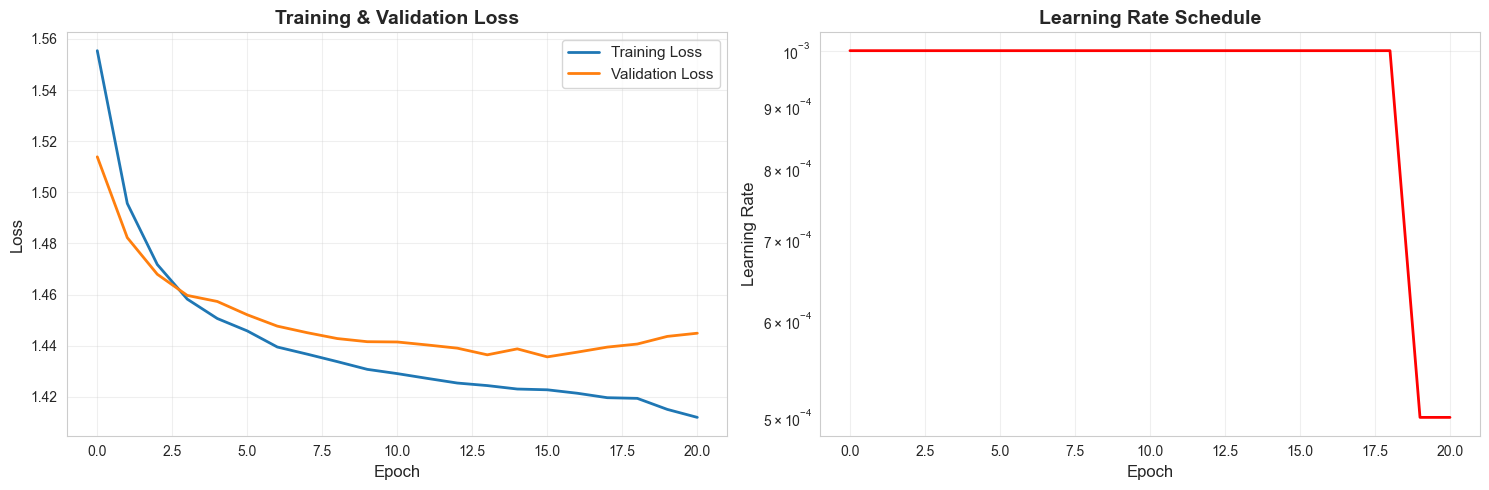

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Learning Rate (if scheduler)
if config.use_lr_scheduler and 'lr' in history.history:
    axes[1].plot(history.history['lr'], linewidth=2, color='red')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Learning Rate', fontsize=12)
    axes[1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[1].set_yscale('log')
    axes[1].grid(True, alpha=0.3)
else:
    axes[1].text(0.5, 0.5, 'No LR Schedule', ha='center', va='center', fontsize=14)
    axes[1].axis('off')

plt.tight_layout()
plt.savefig(f'{config.model_dir}/training_history.png', dpi=150, bbox_inches='tight')
print(f"✅ Gespeichert: {config.model_dir}/training_history.png")
plt.show()

### Predictions vs Actual

✅ Gespeichert: models/predictions_vs_actual.png


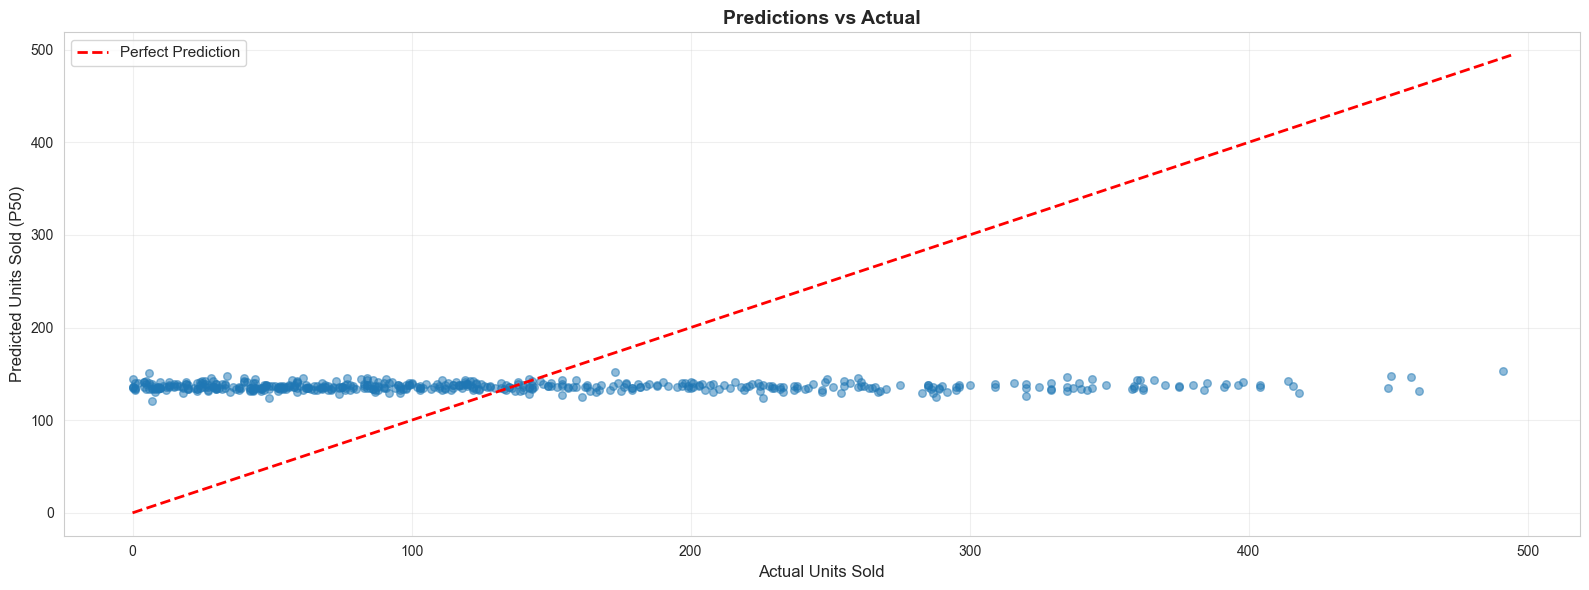

In [13]:
n_samples = min(500, len(y_test_original))
indices = np.random.choice(len(y_test_original), n_samples, replace=False)

plt.figure(figsize=(16, 6))
plt.scatter(y_test_original[indices], p50[indices], alpha=0.5, s=30)
plt.plot([y_test_original.min(), y_test_original.max()], 
         [y_test_original.min(), y_test_original.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Units Sold', fontsize=12)
plt.ylabel('Predicted Units Sold (P50)', fontsize=12)
plt.title('Predictions vs Actual', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'{config.model_dir}/predictions_vs_actual.png', dpi=150, bbox_inches='tight')
print(f"✅ Gespeichert: {config.model_dir}/predictions_vs_actual.png")
plt.show()

## 1️⃣3️⃣ Model & Artefakte speichern

Speichere:
1. **Model** (.keras)
2. **Scaler** (.pkl)
3. **History** (.pkl)
4. **Metrics** (.json)
5. **Config** (.json)

In [14]:
print("💾 Speichere Model & Artefakte...")

# Model Directory erstellen
Path(config.model_dir).mkdir(exist_ok=True)

# 1. Keras Model
model_path = f'{config.model_dir}/deepar_retail_forecast.keras'
model.save(model_path)
print(f"✅ Model:    {model_path}")

# 2. Scaler
scaler_path = f'{config.model_dir}/scalers.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump({'scaler_X': scaler_X, 'scaler_y': scaler_y}, f)
print(f"✅ Scaler:   {scaler_path}")

# 3. History
history_path = f'{config.model_dir}/history.pkl'
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f)
print(f"✅ History:  {history_path}")

# 4. Metrics
metrics_path = f'{config.model_dir}/metrics.json'
with open(metrics_path, 'w') as f:
    json.dump(metrics, f, indent=2)
print(f"✅ Metrics:  {metrics_path}")

# 5. Config
config_path = f'{config.model_dir}/config.json'
config_dict = {
    'seq_length': config.seq_length,
    'batch_size': config.batch_size,
    'lstm_units_1': config.lstm_units_1,
    'lstm_units_2': config.lstm_units_2,
    'feature_cols': feature_cols
}
with open(config_path, 'w') as f:
    json.dump(config_dict, f, indent=2)
print(f"✅ Config:   {config_path}")

print()
print("="*70)
print("✅ TRAINING PIPELINE ABGESCHLOSSEN!")
print("="*70)
print()
print("📦 Gespeicherte Artefakte:")
print(f"   • {model_path}")
print(f"   • {scaler_path}")
print(f"   • {history_path}")
print(f"   • {metrics_path}")
print(f"   • {config_path}")
print()
print("▶️  Nächster Schritt:")
print("   Öffne forecast_deepar.ipynb für Forecasting!")
print("="*70)

💾 Speichere Model & Artefakte...
✅ Model:    models/deepar_retail_forecast.keras
✅ Scaler:   models/scalers.pkl
✅ History:  models/history.pkl
✅ Metrics:  models/metrics.json
✅ Config:   models/config.json

✅ TRAINING PIPELINE ABGESCHLOSSEN!

📦 Gespeicherte Artefakte:
   • models/deepar_retail_forecast.keras
   • models/scalers.pkl
   • models/history.pkl
   • models/metrics.json
   • models/config.json

▶️  Nächster Schritt:
   Öffne forecast_deepar.ipynb für Forecasting!
